In [3]:
from functions.hawkes_process import *
from functions.GOF import *
from functions.compensator import *
from functions.estimator_class import loglikelihood_estimator_bfgs
from functions.estimator_class_multi_rep import *
from functions.multivariate_exponential_process import *
import csv
import scipy

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/rpy2/rinterface_lib/embedded.py:276: UserWarning: R was initialized outside of rpy2 (R_NilValue != NULL). Trying to use it nevertheless.
  warnings.warn(msg)
R was initialized outside of rpy2 (R_NilValue != NULL). Trying to use it nevertheless.


In [4]:
np.random.seed(0) 

### Simulation of a Marked Exponential Hawkes Process

We start by simulating a unidimensionnal Hawkes process denoted $N$. The intensity of the process is given by the formula : 
\begin{equation}
   \lambda(t) =   m + \int_{(-\infty ,t)\times \mathcal{E} } a e^{-b(t-s)} \phi_{\gamma, \psi}(\kappa) N(ds \times d\kappa),
\end{equation}

with $\kappa$ beeing i.i.d. random variable with a  c.d.f $F_\psi$,a dmitiing a density $f_\psi$.

In [4]:
m, a, b = 0.8, -1, 2
Tmax = 5
phi_arg = 0.3

## taking kappa i.i.d following a exponential distribution of parameter 1
def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))

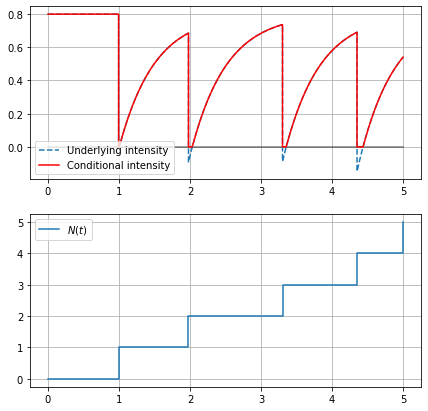

In [5]:
hawkes = exp_thinning_hawkes_marked(m=m,
                                    a=a, 
                                    b=b, 
                                    F = F ,
                                    arg_F = {'psi':1},
                                    phi=phi, 
                                    arg_phi = {'gamma': phi_arg},
                                    max_time = Tmax)


hawkes.simulate()

fig, ax = plt.subplots(2,1, figsize=(7,7))
hawkes.plot_intensity(ax =ax)

We now consider a multidimensionnal Hawkes process for which the intensity $\lambda_i$ of the i-th subprocess takes the form : $\begin{equation}
   \lambda_{i}(t) =   m_i + \sum_{j=1}^{d} \int_{(-\infty ,t)\times \mathcal{E}} a_{ij} e^{-b_i(t-s)} \phi_{\gamma, \psi}(\kappa) N^j(ds \times d\kappa),
\end{equation}$

with $\kappa$ beeing i.i.d. random variable with a  c.d.f $F_\psi$,a dmitiing a density $f_\psi$.

In [6]:
m = np.array([0.5, 0.2]).reshape((2,1))
a = np.array([[0.4, 0.2,], 
                  [-0.4, 0.3]] )
b = np.array([[1],[1.5]])


Tmax = 10
phi_arg = 0.5

def F(mark,time,psi):
    return(scipy.stats.expon.cdf(mark, scale = psi))

def phi(mark, gamma, psi):
    return((psi-gamma)/psi*np.exp(mark*gamma))

def f(mark,t, psi):
    return(psi*np.exp(-psi*mark))

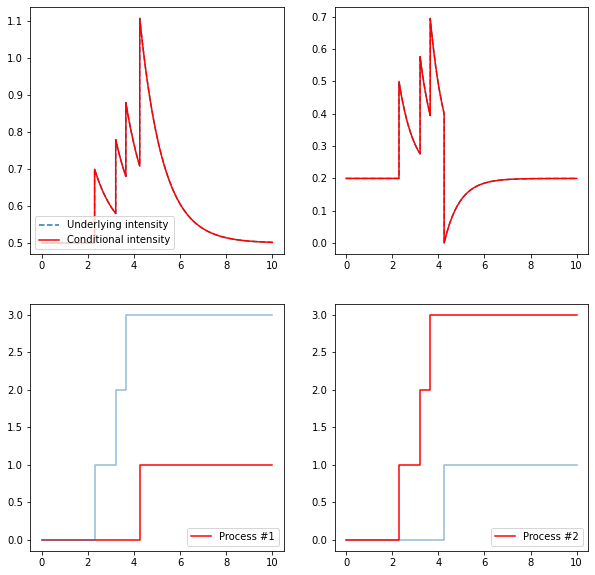

In [7]:
hawkes_multi = multivariate_exponential_hawkes_marked(m=m,
                                                      a=a, 
                                                      b=b, 
                                                      phi = phi, 
                                                      F= F, 
                                                      arg_phi={'gamma':phi_arg}, 
                                                      arg_F={'psi': 2}, 
                                                      max_time=10)

hawkes_multi.simulate()

fig,ax = plt.subplots(2,2, figsize = (10,10))
hawkes_multi.plot_intensity(ax = ax)

# Apply testing procedure

We present here the code use to apply different test procedure on Hawkes process. 

## Test on one coefficient

Simulation of 500 repetition of a bidimensionnal Hawkes process.

In [13]:
np.random.seed(1)

In [14]:
## simualtion of the observations

m = np.array([0.5, 0.8]).reshape((2,1))
a = np.array([[0.4, 0.2], 
                  [0.4, 0.3]] )
b = np.array([[1],[1.5]])


tList = []

for k in range(50):
    process = multivariate_exponential_hawkes( m=m, a=a, b=b , max_time=500)
    process.simulate()
    tList += [process.timestamps]

In [15]:
estimator = estimator_multidim_multi_rep(dimension=2)
estimator.fit(tList)

array([0.59257219, 0.97855874, 0.74219063, 0.12923264, 0.38346765,
       0.3443456 , 5.78601946, 2.81278343])

In [16]:
stat = estimator.test_one_coeff(3,0.4)  
print(stat)

{'estimatorList': array([-0.19206164, -0.3004491 ,  0.07308072, -0.35598978, -0.23063115,
       -0.18004262, -0.14391122, -0.37344448, -0.3447764 ,  0.19451985,
       -0.35171841, -0.00668331, -0.31467381, -0.10891844, -0.16384405,
       -0.38580516, -0.19620722, -0.16011393,  0.33174512, -0.18553084,
       -0.09607226, -1.10967004, -0.21926285, -0.02489827,  0.21295378,
       -0.12867825,  3.30779636, -0.15130432, -0.29509348, -0.19994384,
       -0.54502157, -0.38198019,  0.01881764, -0.27282315, -6.16959151,
       -0.13996926, -0.1970866 , -0.33184314, -0.19377056, -0.15546356,
        0.04545619, -0.05745435, -0.29739123, -0.18323499, -0.24655655,
       -0.10846548, -0.21778397, -0.30644984, -0.17147832, -0.04655952]), 'KStest_stat': 0.3908709426447923, 'KStest_pval': 2.1574222058984363e-07}


### Test of equality between coefficients 

In [18]:
stat = estimator.test_equality_coeff(6,7)

### Test on the model used for estimation

In [5]:
### data generation
m=1
a = -0.6
b = 2.1
Tmax = 500


NbSample = 500
SubSample = int(NbSample**(2/3) )



tList = []

for k in range(50):
    hawkes_ex =   exp_thinning_hawkes(m=m, a = a, b=b, max_time=Tmax)
    hawkes_ex.simulate()
    tList += [hawkes_ex.timestamps]

#%%


learner = estimator_unidim_multi_rep()
learner.fit(tList)


array([ 1.03049845, -0.61903195,  2.04460823])

### Test of the self-exiting assumption

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a poisson model with an unknown parameter} $$

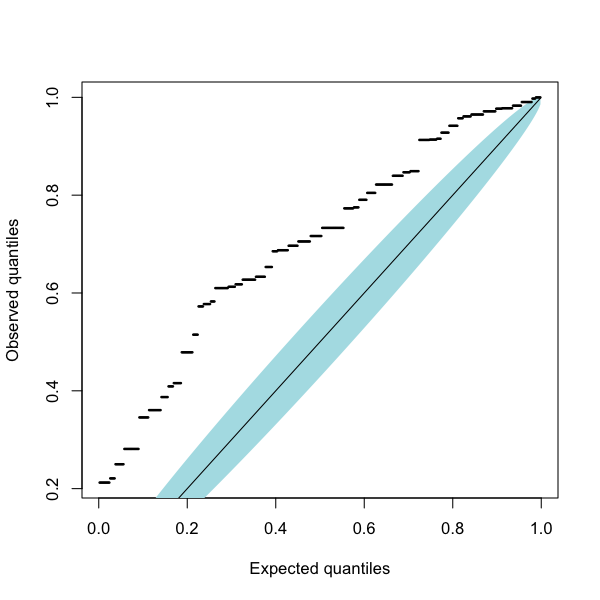

In [6]:
stats_poisson = learner.GOF_bootstrap(compensator_func=poisson_compenasator, sup_compensator=100)


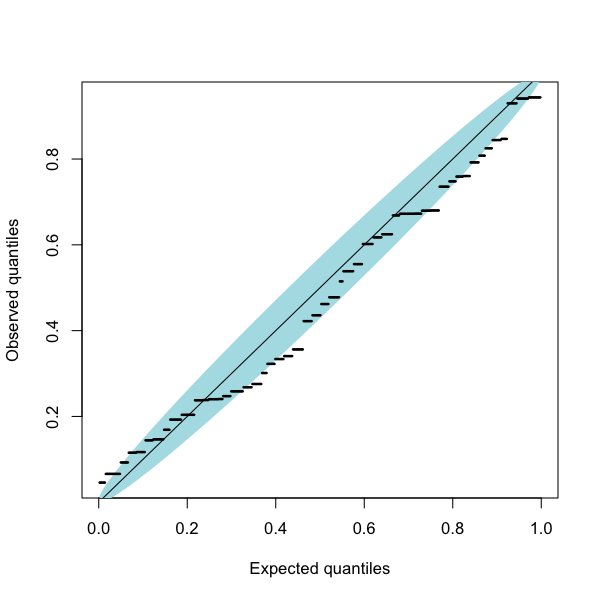

In [7]:
stats_hawkes = learner.GOF_bootstrap(sup_compensator=100)

### Test of the inhibition assumption

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a hawkes model inhibition} $$

In [8]:
learner_hawkes_ex = estimator_unidim_multi_rep(a_bound=0)
learner_hawkes_ex.fit(tList)

array([0.78032001, 0.        , 1.        ])

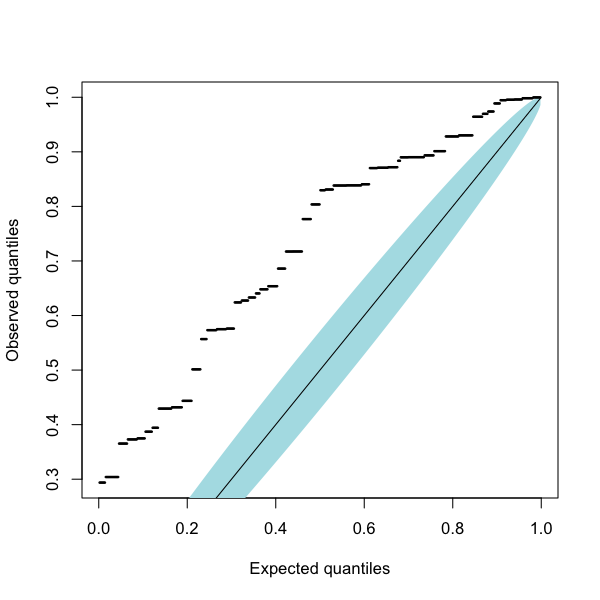

In [10]:
stats_hawkes_ex = learner_hawkes_ex.GOF_bootstrap(sup_compensator=100)

### Test of the marked assumpation

We test here the null hypothesis $$\mathcal{H}_0 : \text{data are i.i.d represetation of a marked hawkes model} $$

# Real dataset